In [112]:
from itertools import cycle, islice
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

from sklearn.decomposition import PCA

import importlib

import imnn
importlib.reload(imnn)
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
import torch.utils.data
from torchvision import datasets, transforms
#sns.set()

import toypipeline
importlib.reload(toypipeline)

LATENT_DIM = 2
DATA_DIM = 784

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
OUTPUT = '/scratch/users/nmiolane/imoutput'

# Inspect Functions

In [113]:
algo_strings = {'vae': 'VAE', 'iwae': 'IWAE', 'vem': 'AVEM'}
crit_strings = {'neg_elbo': 'Neg ELBO', 'neg_iwelbo': 'Neg IWELBO', 'neg_loglikelihood': 'NLL'}
train_val_strings = {'train': 'Train', 'val': 'Valid'}
crit_color_dict = {'neg_elbo': 'red', 'neg_iwelbo': 'orange'}
algo_color_dict = {'vae': 'red', 'iwae': 'orange', 'vem': 'blue'}

In [114]:
def plot_kl_posterior(ax, algo_name='vae', mode='train',
                      from_epoch=0, to_epoch=1000, color='blue', dashes=False):

    neg_elbo = get_losses(algo_name=algo_name, crit_name='neg_elbo', mode=mode)
    neg_ll = get_losses(algo_name=algo_name, crit_name='neg_loglikelihood', mode=mode)

    kl = [nelbo - nll for (nelbo, nll) in zip(neg_elbo, neg_ll)]
    
    n_epochs = len(kl)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)

    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} KL'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    return ax

In [115]:
def get_losses(algo_name='vae', crit_name='neg_elbo', mode='train'):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/{mode}_losses.pkl')
    if len(losses_path) == 0:
        ckpts = glob.glob(f'{OUTPUT}/train_{algo_name}/models/epoch_*_checkpoint.pth')
        if len(ckpts) == 0:
            print(f'{algo_strings[algo_name]}: No {mode}_losses.pkl found. No checkpoints found.')
        else:
            ckpts_ids_and_paths = [(int(f.split('_')[2]), f) for f in ckpts]
            ckpt_id, ckpt_path = max(
                ckpts_ids_and_paths, key=lambda item: item[0])
            print('Found checkpoints. Getting: %s.' % ckpt_path)
            ckpt = torch.load(ckpt_path, map_location=DEVICE)
            
            losses = ckpt[f'{mode}_losses']
            losses = [loss[crit_name] for loss in losses]

    else:
        losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/{mode}_losses.pkl')[0]
        losses = pickle.load(open(losses_path, 'rb'))
        losses = [loss[crit_name] for loss in losses]
    return losses

In [116]:
def plot_criterion(ax, algo_name='vae', crit_name='neg_elbo', mode='train', 
                   from_epoch=0, to_epoch=1000, color='blue', dashes=False):
    if crit_name == 'kl_post':
        return plot_kl_posterior(
            ax=ax, algo_name=algo_name, mode=mode, 
            from_epoch=from_epoch, to_epoch=to_epoch, color=color, dashes=dashes)
    
    losses_total = get_losses(algo_name=algo_name, crit_name=crit_name, mode=mode)
    
    n_epochs = len(losses_total)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)
    
    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} {crit_strings[crit_name]}'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], losses_total[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], losses_total[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    ax.legend()
    return ax

# Comparison of Convergences

In [117]:
from_epoch = 0
to_epoch = 15

Found checkpoints. Getting: /scratch/users/nmiolane/imoutput/train_vae/models/epoch_0_checkpoint.pth.
IWAE: No train_losses.pkl found. No checkpoints found.


UnboundLocalError: local variable 'losses' referenced before assignment

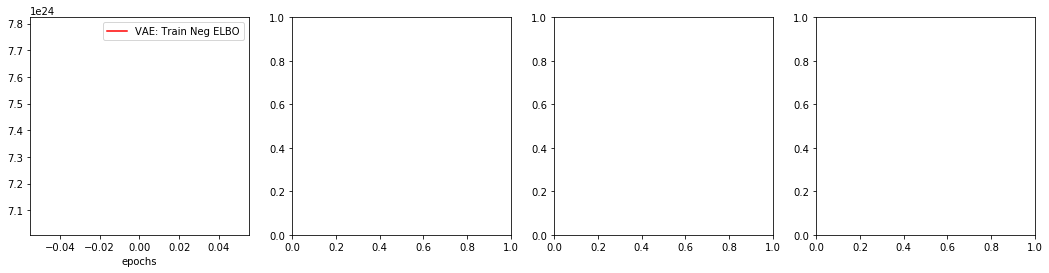

In [119]:
def plot_convergence(ax, algo_name, crit_name):
    ax = plot_criterion(ax, algo_name=algo_name, crit_name=crit_name, mode='train', 
                    from_epoch=from_epoch, to_epoch=to_epoch, color=crit_color_dict[crit_name])
    #ax = plot_criterion(ax, algo_name=algo_name, crit_name=crit_name, mode='val', 
    #                from_epoch=from_epoch, to_epoch=to_epoch, color=crit_color_dict[crit_name], dashes=True)
    #ax.set_title(f'Convergence of {algo_strings[algo_name]}.')
    return ax

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = plot_convergence(ax, 'vae', 'neg_elbo')

ax = axes[0]
ax = plot_convergence(ax, 'iwae', 'neg_iwelbo')

ax = axes[2]
ax = plot_convergence(ax, 'vem', 'neg_elbo')
ax = axes[3]
ax = plot_convergence(ax, 'vem', 'neg_iwelbo')

Found checkpoints. Getting: /scratch/users/nmiolane/imoutput/train_vem/models/epoch_2_checkpoint.pth.
Found checkpoints. Getting: /scratch/users/nmiolane/imoutput/train_vem/models/epoch_2_checkpoint.pth.
Found checkpoints. Getting: /scratch/users/nmiolane/imoutput/train_vem/models/epoch_2_checkpoint.pth.


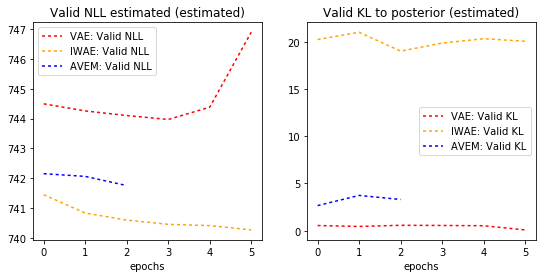

In [100]:
def plot_nll(ax, algo_name):
    # ax = plot_criterion(ax, algo_name=algo_name, crit_name='neg_loglikelihood', mode='train', 
    #                from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name])
    ax = plot_criterion(ax, algo_name=algo_name, crit_name='neg_loglikelihood', mode='val', 
                    from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=True)
    return ax

def plot_kl(ax, algo_name):
    # ax = plot_kl_posterior(ax, algo_name=algo_name, mode='train',
    #                   from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=False)
    ax = plot_criterion(ax, algo_name=algo_name, crit_name='kl_post', mode='val',
                      from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=True)
    
    return ax

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax = axes[0]
ax = plot_nll(ax, 'vae')
ax = plot_nll(ax, 'iwae')
ax = plot_nll(ax, 'vem')
ax.set_title('Valid NLL estimated (estimated)')

ax = axes[1]
ax = plot_kl(ax, 'vae')
ax = plot_kl(ax, 'iwae')
ax = plot_kl(ax, 'vem')
ax.set_title('Valid KL to posterior (estimated)')
ax.legend()

# Inspect latent spaces

In [85]:
def load_module(algo_name='vae', module_name='encoder'):
    module_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/{module_name}.pth')
    if len(module_path) == 0:
        ckpts = glob.glob(f'{OUTPUT}/train_{algo_name}/models/epoch_*_checkpoint.pth')
        if len(ckpts) == 0:
            print('No module found. No checkpoints found.')
        else:
            ckpts_ids_and_paths = [(int(f.split('_')[2]), f) for f in ckpts]
            ckpt_id, ckpt_path = max(
                ckpts_ids_and_paths, key=lambda item: item[0])
            print('Found checkpoints. Getting: %s.' % ckpt_path)
            ckpt = torch.load(ckpt_path, map_location=DEVICE)
            
            vae = imnn.VAE(
                latent_dim=LATENT_DIM,
                data_dim=DATA_DIM)
            vae.to(DEVICE)

            modules = {}
            modules['encoder'] = vae.encoder
            modules['decoder'] = vae.decoder
            module = modules[module_name]
            module_ckpt = ckpt[module_name]
            module.load_state_dict(module_ckpt['module_state_dict'])   
        
    else:
        module_path = module_path[0]
        print('Loading: %s' % module_path)
        module = torch.load(module_path, map_location=DEVICE)
    return module

In [86]:
m = load_module()
print(m)

Loading: /scratch/users/nmiolane/imoutput/train_vae/models/encoder.pth
Encoder(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc1a): Linear(in_features=400, out_features=400, bias=True)
  (fc1b): Linear(in_features=400, out_features=400, bias=True)
  (fc1c): Linear(in_features=400, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=2, bias=True)
  (fc22): Linear(in_features=400, out_features=2, bias=True)
)


In [87]:
def latent_space_pca(val_dataset, n_components, algo_name='vae'):
    encoder = load_module(algo_name, 'encoder')

    mus = []
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, **KWARGS)
    for i, data in enumerate(val_loader):
        data = data[0].to(DEVICE)
        data = data.view(-1, 784)
        mu, logvar = encoder(data)
        mu = np.array(mu.cpu().detach())
        mus.append(mu)

    mus = np.vstack(mus).squeeze()

    pca = PCA(n_components=n_components)
    pca.fit(mus)
    projected_mus = pca.transform(mus)
    return projected_mus

In [88]:
def plot_pca(ax, val_dataset, algo_name='vae'):
    projected_mus = latent_space_pca(val_dataset, n_components=2, algo_name=algo_name)
    val_labels = val_dataset.test_labels
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                      '#999999', '#e41a1c', '#dede00']),
                                      int(max(val_labels) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    sc = ax.scatter(projected_mus[:, 0], projected_mus[:, 1], s=10, color=colors[val_labels])
    #legend = ax.legend(*sc.legend_elements(), title='Labels')
    #ax.add_artist(legend)
    #ax.legend()
    ax.set_title(algo_strings[algo_name])
    return ax

Loading: /scratch/users/nmiolane/imoutput/train_vae/models/encoder.pth
Loading: /scratch/users/nmiolane/imoutput/train_iwae/models/encoder.pth
Loading: /scratch/users/nmiolane/imoutput/train_vem/models/encoder.pth


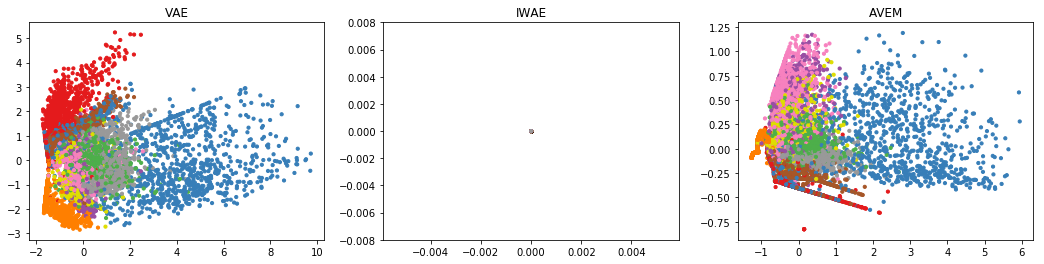

In [89]:
BATCH_SIZE = 32
KWARGS = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

val_dataset = datasets.MNIST(
    '../data', download=True, train=False, transform=transforms.ToTensor())


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax = axes[0]
ax = plot_pca(ax, val_dataset, 'vae')

ax = axes[1]
ax = plot_pca(ax, val_dataset, 'iwae')

ax = axes[2]
ax = plot_pca(ax, val_dataset, 'vem')

# Inspect active units

# Comparison of times

In [24]:
def print_average_time(algo_name='vae'):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    losses_all_epochs = pickle.load(open(losses_path, 'rb'))
    
    times = [loss['total_time'] for loss in losses_all_epochs]
    print(np.mean(times))
    
print_average_time('vae')
print_average_time('iwae')
print_average_time('vem')

4.085375881195068
7.1483808070421215
7.228731715679169


# Print pipeline logs

In [160]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

Found 1 log files.

-- Log file: logs2019-05-17 22:05:22.503695.txt

2019-05-17 22:05:22,503 root         INFO     start
2019-05-17 22:05:22,518 luigi        INFO     logging configured by default settings
2019-05-17 22:05:22,542 luigi-interface DEBUG    Checking if RunAll() is complete
2019-05-17 22:05:22,543 luigi-interface DEBUG    Checking if Report() is complete
2019-05-17 22:05:22,543 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-05-17 22:05:22,544 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-05-17 22:05:22,544 luigi-interface DEBUG    Checking if TrainIWAE() is complete
2019-05-17 22:05:22,545 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-05-17 22:05:22,545 luigi-interface INFO     Informed scheduler that task   Report__99914b932b   has status   PENDING
2019-05-17 22:05:22,546 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-05-17 22:05:22,546 luigi-interface INFO  